# # IMPORTS

In [1]:
import matplotlib.pyplot as plt 
import pandas as pd  
import statsmodels.api as sm  
import pylab as pl  
import numpy as np  
from patsy import dmatrix 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score


def retorna_values(dataset,coluna):
    values = dataset.iloc[:,coluna]
    return values

def curva_roc(string,clf):
    logit_roc_auc = roc_auc_score(y_test, clf.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:,1])
    plt.figure()
    plt.plot(fpr, tpr, label=string % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('Log_ROC')
    plt.show()
    return

# CARREGANDO OS DADOS
# Dados das tabelas Cartao, Carne e Cadastral

In [2]:
dfLimite = pd.read_csv("C:\CSCORE\TABELAO_CARTAO_TARGET_ELEGIVEL.txt", sep='\t')
dfLimite = dfLimite[dfLimite["FLAG_TARGET"] >= 0]
dfLimite = dfLimite.groupby('CODIGO_CLIENTE')['LIMITE'].max()
dfLimite = dfLimite.to_frame()
dfLimite['CODIGO_CLIENTE'] = dfLimite.index
dfLimite['FLAG_CARTAO'] = 1

dfCarne = pd.read_csv("C:\CSCORE\TABELAO_CARNE.txt", sep='\t')
dfCarne = dfCarne[dfCarne["FLAG_TARGET"] >= 0]
dfCarne = dfCarne.groupby('CODIGO_CLIENTE')['VALOR_PARCELA'].mean()
dfCarne = dfCarne.to_frame()
dfCarne['CODIGO_CLIENTE'] = dfCarne.index
dfCarne['FLAG_CARNE'] = 1


df = pd.read_csv("C:\CSCORE\TABELAO_1.txt", sep='\t')
df = retorna_values(df,[1,3,4,7,8,11,12,13,14,15,16,17,18,19,20])
df = df[df["FLAG_TARGET"] >= 0]

df = df.merge(dfLimite, left_on='CODIGO_CLIENTE', right_on='CODIGO_CLIENTE', how='outer') # adicionado a coluna LIMITE
df = df.merge(dfCarne, left_on='CODIGO_CLIENTE', right_on='CODIGO_CLIENTE', how='outer')

C:\Users\adans\Anaconda\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: 'CODIGO_CLIENTE' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
C:\Users\adans\Anaconda\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: 'CODIGO_CLIENTE' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version


# TRATAMENTO DOS DADOS

In [3]:
#CONVERTENDO A IDADE EM DIAS(TIMEDELTA) EM ANOS(INT)

df['IDADE'] = pd.to_timedelta(df['IDADE'])
td = df['IDADE']
df['IDADE'] = pd.to_numeric(td.dt.days/365)


#GERANDO OS DUMMIES PARA SEXO, ESTADO_CIVIL, CATEGORIA PROFISSIONAL, TIPO DE RESIDENCIA
sexo = pd.get_dummies(df['SEXO'], drop_first=True)
estado_civil = pd.get_dummies(df['ESTADO_CIVIL'], drop_first=True)
categoria_prof = pd.get_dummies(df['CATEGORIAL_PROFISSAO'], drop_first=True)
tipo_residencia = pd.get_dummies(df['TIPO_RESIDENCIA'], drop_first=True)


#PREENCHENDO OS NAN COM 'N'
df['FLAG_CONTA_BANCO'] = df['FLAG_CONTA_BANCO'].fillna('N')
df['LIMITE'] = df['LIMITE'].fillna(0)
df['FLAG_CARTAO'] = df['FLAG_CARTAO'].fillna(0)

df['VALOR_PARCELA'] = df['VALOR_PARCELA'].fillna(0)
df['FLAG_CARNE'] = df['FLAG_CARNE'].fillna(0)

#CRIANDO DUMMIES PARA FLAG_CONTA_BANCO

flag_conta_banco = pd.get_dummies(df['FLAG_CONTA_BANCO'], drop_first = True)

#CONVERTER tudo PARA NUMERO
df = df.apply(pd.to_numeric, errors='coerce')#CONVERTER tudo PARA NUMERO

df = df.drop('CODIGO_CLIENTE', axis=1)
df = df.drop('BAIRRO', axis=1)
df = df.drop('ESTADO_CIVIL', axis=1)
df = df.drop('SEXO', axis=1)
df = df.drop('CATEGORIAL_PROFISSAO', axis=1)
df = df.drop('TIPO_RESIDENCIA', axis=1)
df = df.drop('FLAG_CONTA_BANCO', axis=1)
df = df.drop('QTD_CARTOES_ADICIONAIS', axis=1)

#CRIA O DF para o tabelao
df = pd.concat([df, sexo, estado_civil, categoria_prof, tipo_residencia, flag_conta_banco],axis=1)

# PREENCHENDO OS VAZIOS

In [4]:
from sklearn.preprocessing import Imputer

imp1 = Imputer(missing_values = 'NaN', strategy='median', axis=0)
imp2 = Imputer(missing_values = 'NaN', strategy='median', axis=0)
imp3 = Imputer(missing_values = 'NaN', strategy='median', axis=0)
imp4 = Imputer(missing_values = 'NaN', strategy='median', axis=0)
imp5 = Imputer(missing_values = 'NaN', strategy='median', axis=0)

"""
imp1.fit(df['RENDA_CJ'].values.reshape(-1,1))
df['RENDA_CJ'] = imp1.transform(df['RENDA_CJ'].values.reshape(-1,1))

imp2.fit(df['RENDA_TITULAR'].values.reshape(-1,1))
df['RENDA_TITULAR'] = imp2.transform(df['RENDA_TITULAR'].values.reshape(-1,1))

imp3.fit(df['OUTRAS_RENDAS'].values.reshape(-1,1))
df['OUTRAS_RENDAS'] = imp3.transform(df['OUTRAS_RENDAS'].values.reshape(-1,1))
"""

imp4.fit(df['IDADE'].values.reshape(-1,1))
df['IDADE'] = imp4.transform(df['IDADE'].values.reshape(-1,1))

imp5.fit(df['LIMITE'].values.reshape(-1,1))
df['LIMITE'] = imp5.transform(df['LIMITE'].values.reshape(-1,1))

df['RENDA_CJ'] = df['RENDA_CJ'].fillna(0)
df['RENDA_TITULAR'] = df['RENDA_TITULAR'].fillna(0)
df['OUTRAS_RENDAS'] = df['OUTRAS_RENDAS'].fillna(0)
df['IDADE'] = df['IDADE'].astype(int)
df['IDADE'] = df['IDADE'].fillna(0)
df['QTD_DEPENDENTES'] = df['QTD_DEPENDENTES'].fillna(0)
"""
df['RENDA_CJ'] = df['RENDA_CJ']/1000
df['RENDA_TITULAR'] = df['RENDA_TITULAR']/1000
df['LIMITE'] = df['LIMITE']/1000
df['OUTRAS_RENDAS'] = df['OUTRAS_RENDAS']/1000
df['VALOR_HISTORICO_COMPRAS'] = df['VALOR_HISTORICO_COMPRAS']/1000
df['VALOR_PARCELA'] = df['VALOR_PARCELA']/100
df['IDADE'] = df['IDADE']/10
dfBase = df
"""

C:\Users\adans\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:58: DeprecationWarning: Class Imputer is deprecated; 

"\ndf['RENDA_CJ'] = df['RENDA_CJ']/1000\ndf['RENDA_TITULAR'] = df['RENDA_TITULAR']/1000\ndf['LIMITE'] = df['LIMITE']/1000\ndf['OUTRAS_RENDAS'] = df['OUTRAS_RENDAS']/1000\ndf['VALOR_HISTORICO_COMPRAS'] = df['VALOR_HISTORICO_COMPRAS']/1000\ndf['VALOR_PARCELA'] = df['VALOR_PARCELA']/100\ndf['IDADE'] = df['IDADE']/10\ndfBase = df\n"

#  DESCRIÇÃO DOS DADOS

In [5]:
print("DATA SUMMARY")
print(df.describe())

print("DESVIO PADRAO")
print(df.std())

DATA SUMMARY
       QTD_DEPENDENTES  RENDA_TITULAR      RENDA_CJ  OUTRAS_RENDAS  \
count     96228.000000   96228.000000  96228.000000   96228.000000   
mean          0.357360    1599.269776     68.518331     120.618843   
std           0.758963    1411.516164    427.106584     437.608688   
min           0.000000       0.000000      0.000000       0.000000   
25%           0.000000    1000.000000      0.000000       0.000000   
50%           0.000000    1342.000000      0.000000       0.000000   
75%           0.000000    1900.000000      0.000000       0.000000   
max          10.000000  180000.000000  30000.000000   39000.000000   

       VALOR_HISTORICO_COMPRAS   FLAG_TARGET         IDADE        LIMITE  \
count             96228.000000  96228.000000  96228.000000  96228.000000   
mean               2497.607626      0.744949     41.150289    856.428545   
std                3068.072788      0.435892     16.117914    950.588236   
min                   0.000000      0.000000     19.

# #DROPS

In [6]:
#df = pd.concat([df, sexo, estado_civil, categoria_prof, tipo_residencia, flag_conta_banco],axis=1)
#df =df.drop('IDADE', axis=1)
#df = df.drop('RENDA_CJ', axis=1)
#df = df.drop('RENDA_TITULAR', axis=1)
#df = df.drop('OUTRAS_RENDAS', axis=1)
#df = df.drop('VALOR_HISTORICO_COMPRAS', axis=1)
#df = df.drop('VALOR_PARCELA', axis=1)
#df = df.drop('LIMITE', axis =1 )
#df = df.drop('FLAG_CARTAO', axis=1)
#df = df.drop('FLAG_CARNE', axis=1)
#df = df.drop('RENDA', axis=1)

# DIVIDINDO A BASE DE DADOS

In [7]:
X = df.drop('FLAG_TARGET', axis=1)
y = df['FLAG_TARGET']

sc = StandardScaler()
X1 =  sc.fit_transform(X)

C:\Users\adans\Anaconda\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype uint8, int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


# BALANCEANDO OS DADOS

In [8]:
from imblearn.over_sampling import SMOTE

os = SMOTE(random_state=0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
columns = X_train.columns

os_data_X,os_data_y=os.fit_sample(X_train, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
os_data_y= pd.DataFrame(data=os_data_y,columns=['FLAG_TARGET'])
# we can Check the numbers of our data
print("length of oversampled data is ",len(os_data_X))
print("Number of no subscription in oversampled data",len(os_data_y[os_data_y['FLAG_TARGET']==0]))
print("Number of subscription",len(os_data_y[os_data_y['FLAG_TARGET']==1]))
print("Proportion of no subscription data in oversampled data is ",len(os_data_y[os_data_y['FLAG_TARGET']==0])/len(os_data_X))
print("Proportion of subscription data in oversampled data is ",len(os_data_y[os_data_y['FLAG_TARGET']==1])/len(os_data_X))

length of oversampled data is  100268
Number of no subscription in oversampled data 50134
Number of subscription 50134
Proportion of no subscription data in oversampled data is  0.5
Proportion of subscription data in oversampled data is  0.5


In [9]:
data_final_vars=df.columns.values.tolist()
y=['FLAG_TARGET']
X=[i for i in data_final_vars if i not in y]

# VERIFICANDO AS VARIAVEIS

In [10]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()

rfe = RFE(logreg, 20)
rfe = rfe.fit(os_data_X, os_data_y.values.ravel())
print(rfe.support_)
print(rfe.ranking_)

X=os_data_X
y=os_data_y['FLAG_TARGET']

C:\Users\adans\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\adans\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this w

[ True False False False False  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True]
[1 4 6 2 3 1 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [11]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.646350
         Iterations 6
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.068      
Dependent Variable:   FLAG_TARGET        AIC:                129666.3454
Date:                 2019-02-13 13:30   BIC:                129904.2354
No. Observations:     100268             Log-Likelihood:     -64808.    
Df Model:             24                 LL-Null:            -69500.    
Df Residuals:         100243             LLR p-value:        0.0000     
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       6.0000                                            
------------------------------------------------------------------------
                         Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------------
QTD_DEPENDENTES          0.1064   0.0098  10.8724 0

# Drops após analise

In [12]:
X = X.drop('M', axis=1)
X = X.drop('CO', axis=1)
#X = X.drop('OU', axis=1)
X = X.drop('LIBERAL', axis=1)
#X = X.drop('RENDA_CJ', axis=1)
#X = X.drop('AUT+NOMO', axis=1)

# Aplicação de modelos

# 1. Regressão Logistica

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
print(accuracy_score(y_test,y_pred))

C:\Users\adans\Anaconda\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy of logistic regression classifier on test set: 0.64
[[9747 5244]
 [5730 9360]]
              precision    recall  f1-score   support

         0.0       0.63      0.65      0.64     14991
         1.0       0.64      0.62      0.63     15090

   micro avg       0.64      0.64      0.64     30081
   macro avg       0.64      0.64      0.64     30081
weighted avg       0.64      0.64      0.64     30081

0.6351850004986537


# Curva Roc

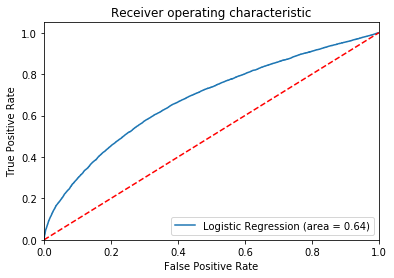

In [14]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

# 2. MLP (25,19,19, n=500)

In [15]:
print("MODELO 2.")
print("MODELO REDES NEURAIS")
print()

sc = StandardScaler()
X1 =  sc.fit_transform(X)

from sklearn.neural_network import MLPClassifier

X_train,X_test,y_train,y_test = train_test_split(X1,y,test_size=0.3,train_size=0.7)
mlp = MLPClassifier(hidden_layer_sizes=(23,19,19),max_iter=500)

mlp.fit(X_train,y_train)

predictions = mlp.predict(X_test)

from sklearn.metrics import classification_report,confusion_matrix
print("X1")
print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("X1:ACCURACY:")
print(accuracy_score(y_test,predictions))
print()


MODELO 2.
MODELO REDES NEURAIS

X1
[[ 9473  5641]
 [  614 14353]]
              precision    recall  f1-score   support

         0.0       0.94      0.63      0.75     15114
         1.0       0.72      0.96      0.82     14967

   micro avg       0.79      0.79      0.79     30081
   macro avg       0.83      0.79      0.79     30081
weighted avg       0.83      0.79      0.79     30081

X1:ACCURACY:
0.7920614341278548



Decision tree
[[11481  3497]
 [ 3735 11368]]
              precision    recall  f1-score   support

         0.0       0.75      0.77      0.76     14978
         1.0       0.76      0.75      0.76     15103

   micro avg       0.76      0.76      0.76     30081
   macro avg       0.76      0.76      0.76     30081
weighted avg       0.76      0.76      0.76     30081

ACCURACY:
0.7595824606894718

CrossValidation score:
0.7503409346529779


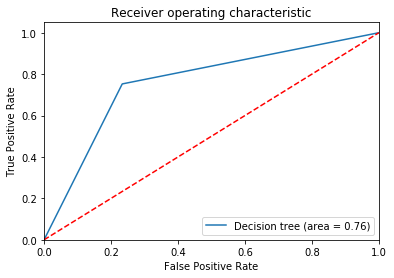

===Random forest===
[[10961  4017]
 [ 1393 13710]]
              precision    recall  f1-score   support

         0.0       0.89      0.73      0.80     14978
         1.0       0.77      0.91      0.84     15103

   micro avg       0.82      0.82      0.82     30081
   macro avg       0.83      0.82      0.82     30081
weighted avg       0.83      0.82      0.82     30081

ACCURACY:
0.8201522555766099

CrossValidation score:
0.8030902300871231


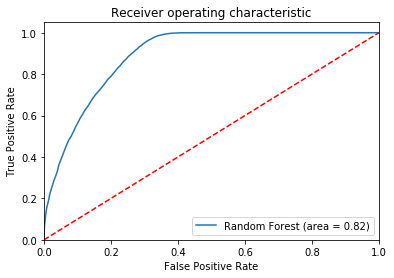

===EXTRA TREE===
[[11015  3963]
 [ 1604 13499]]
              precision    recall  f1-score   support

         0.0       0.87      0.74      0.80     14978
         1.0       0.77      0.89      0.83     15103

   micro avg       0.81      0.81      0.81     30081
   macro avg       0.82      0.81      0.81     30081
weighted avg       0.82      0.81      0.81     30081

ACCURACY:
0.8149330141950069

CrossValidation score:
0.8017338126217401


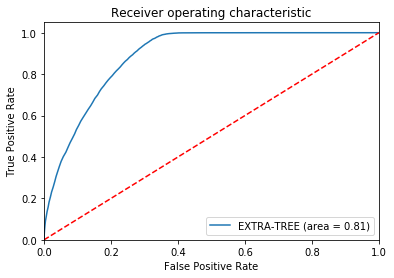

===GRADIENTE BOOST===
[[6922 3119]
 [ 517 9496]]
              precision    recall  f1-score   support

         0.0       0.93      0.69      0.79     10041
         1.0       0.75      0.95      0.84     10013

   micro avg       0.82      0.82      0.82     20054
   macro avg       0.84      0.82      0.82     20054
weighted avg       0.84      0.82      0.82     20054

ACCURACY:
0.8186895382467339



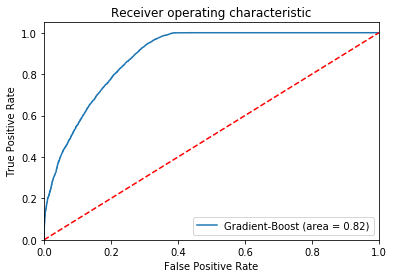

In [16]:
from sklearn.model_selection import cross_val_score
from sklearn.datasets import make_blobs
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier

arvores = 100

#X, y = make_blobs(n_samples=96228, n_features=27, centers=2, random_state=0)

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,train_size=0.7)
print("============================")
print("Decision tree")
clf = DecisionTreeClassifier(max_depth=None, min_samples_split=2,random_state=0)
clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("ACCURACY:")
print(accuracy_score(y_test,predictions))
print()

scores = cross_val_score(clf, X, y, cv=5)
print("CrossValidation score:")
print(scores.mean())                               
curva_roc('Decision tree (area = %0.2f)',clf)

print("===Random forest===")
clf = RandomForestClassifier(n_estimators=arvores, max_depth=None, min_samples_split=2, random_state=0)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("ACCURACY:")
print(accuracy_score(y_test,predictions))
print()

scores = cross_val_score(clf, X, y, cv=5)
print("CrossValidation score:")
print(scores.mean())

curva_roc('Random Forest (area = %0.2f)',clf)

print("===EXTRA TREE===")
clf = ExtraTreesClassifier(n_estimators=arvores, max_depth=None,min_samples_split=2, random_state=0)

clf.fit(X_train, y_train)
predictions = clf.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("ACCURACY:")
print(accuracy_score(y_test,predictions))
print()

scores = cross_val_score(clf, X, y, cv=5)
print("CrossValidation score:")
print(scores.mean())

curva_roc('EXTRA-TREE (area = %0.2f)',clf)

print('===GRADIENTE BOOST===')
from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import r2_score

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,train_size=0.8)

params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 2,
          'learning_rate': 0.01 }

clf = ensemble.GradientBoostingClassifier(**params)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print("ACCURACY:")
print(accuracy_score(y_test,predictions))
print()

curva_roc('Gradient-Boost (area = %0.2f)',clf)

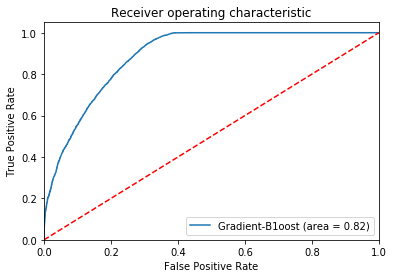

In [17]:
curva_roc('Gradient-B1oost (area = %0.2f)',clf)

In [18]:
scores = cross_val_score(clf, X, y, cv=5)
print("CrossValidation score:")
print(scores.mean())

CrossValidation score:
0.8003877999379732
